In [1]:
import os
import tensorflow as tf
import numpy as np
import itertools
import matplotlib.pyplot as plt
import gc
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

<h2>Carregamento dos Dados</h2>

In [2]:
input_label = []
output_label = []

In [3]:
a,b = 0,0
ficheiro = open("..\\..\\Dataset\\02-03-2018.csv", "r")
nome_label = ficheiro.readline().split(",")
ficheiro.readline()
ficheiro.readline()
linha = ficheiro.readline()
while(linha != ""):
    linha = linha.split(",")
    out = linha.pop(37)
    if(out == "Benign"): 
        out = 0
        b += 1
    else: 
        out = 1
        a += 1
    output_label.append(out)
    input_label.append(linha)
    linha = ficheiro.readline()
ficheiro.close()
print(str(a) + " " + str(b))

286191 758334


In [4]:
backup_input_label = input_label[:]
backup_output_label = output_label[:]

In [ ]:
input_label = backup_input_label[:]
output_label = backup_output_label[:]

<h2>Normalização dos Dados</h2>

In [5]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(input_label)
input_label = scaler.transform(input_label)

In [6]:
inp_train,inp_test,out_train,out_test = train_test_split(input_label, input_label, test_size=0.2)

<h2>Construção Das Redes</h2>

In [7]:
input_model = layers.Input(shape = (78,))
enc = layers.Dense(units = 64, activation = "relu", use_bias = True)(input_model)
enc = layers.Dense(units = 36, activation = "relu")(enc)
dec = layers.Dense(units = 64, activation = "relu", use_bias = True)(enc)
dec = layers.Dense(units = 78, activation = "relu", use_bias = True)(dec)
auto_encoder = keras.Model(input_model, dec)

In [8]:
encoder = keras.Model(input_model, enc)
decoder_input = layers.Input(shape = (36,))
decoder_layer = auto_encoder.layers[-2](decoder_input)
decoder_layer = auto_encoder.layers[-1](decoder_layer)
decoder = keras.Model(decoder_input, decoder_layer)

In [9]:
auto_encoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00025), loss = "mean_squared_error", metrics = ['accuracy'])

<h2>Treino</h2>

In [10]:
train = auto_encoder.fit(x = inp_train, y = out_train,validation_split= 0.1, epochs = 5, verbose = 1, shuffle = True)

Epoch 1/5
23502/23502 [==============================] - 41s 2ms/step - loss: 0.0135 - accuracy: 0.4970 - val_loss: 0.0125 - val_accuracy: 0.5257
Epoch 2/5
23502/23502 [==============================] - 23s 973us/step - loss: 0.0124 - accuracy: 0.5079 - val_loss: 0.0124 - val_accuracy: 0.5010
Epoch 3/5
23502/23502 [==============================] - 24s 1ms/step - loss: 0.0124 - accuracy: 0.5093 - val_loss: 0.0124 - val_accuracy: 0.49820.0124 - accuracy:  - ETA: 0s - loss: - ETA: 0s - loss: 0.0124 - accuracy: 0.50
Epoch 4/5
23502/23502 [==============================] - 24s 1ms/step - loss: 0.0124 - accuracy: 0.5095 - val_loss: 0.0124 - val_accuracy: 0.5032
Epoch 5/5
23502/23502 [==============================] - 25s 1ms/step - loss: 0.0124 - accuracy: 0.5100 - val_loss: 0.0124 - val_accuracy: 0.5016


In [23]:
encoder.save("autoencoder36.h5")

## Teste

In [11]:
input_label = backup_input_label[:]
output_label = backup_output_label[:]

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(input_label)
input_label = scaler.transform(input_label)

In [13]:
input_label = encoder.predict(input_label).reshape(len(input_label), 36, 1)
output_label = np.array(output_label)

In [14]:
input_label, output_label = shuffle(input_label, output_label)

In [15]:
inp_train, inp_test, out_train, out_test = train_test_split(input_label, output_label, test_size = 0.2)

In [16]:
model = keras.Sequential([
    layers.Input(shape = (36,1)),
    layers.Conv1D(filters = 32, kernel_size = 3, padding = "same", activation = "relu", use_bias = True),
    layers.MaxPool1D(pool_size = 3),
    layers.Conv1D(filters = 16, kernel_size = 3, padding = "same", activation = "relu", use_bias = True),
    layers.MaxPool1D(pool_size = 3),
    layers.Flatten(),
    layers.Dense(units = 2, activation = "softmax")
])

In [17]:
model.compile(optimizer= keras.optimizers.SGD(learning_rate= 0.08), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [18]:
treino = model.fit(x = inp_train, y = out_train, validation_split= 0.1, epochs = 5, shuffle = True,verbose = 1)

Epoch 1/5
23502/23502 [==============================] - 54s 2ms/step - loss: 0.0754 - accuracy: 0.9695 - val_loss: 0.0069 - val_accuracy: 0.9983
Epoch 2/5
23502/23502 [==============================] - 52s 2ms/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0046 - val_accuracy: 0.9989
Epoch 3/5
23502/23502 [==============================] - 51s 2ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 4/5
23502/23502 [==============================] - 53s 2ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0028 - val_accuracy: 0.9991
Epoch 5/5
23502/23502 [==============================] - 53s 2ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0028 - val_accuracy: 0.9992


In [19]:
res = [np.argmax(resu) for resu in model.predict(inp_test)]

In [20]:
cm = confusion_matrix(y_true = out_test.reshape(len(out_test)), y_pred = np.array(res))

In [21]:
def plot_confusion_matrix(cm, classes, normaliza = False, title = "Confusion matrix", cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normaliza:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[151394    126]
 [    13  57372]]


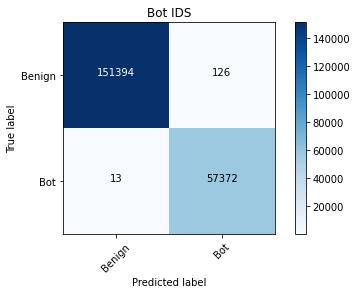

In [22]:
labels = ["Benign", "Bot"]
plot_confusion_matrix(cm = cm, classes = labels, title = "Bot IDS")